In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import datetime
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: amandubey11
Your Kaggle Key: ········


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.20G/5.20G [4:59:09<00:00, 311kB/s]


In [26]:
df = pd.read_csv('skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.shape

(10015, 7)

In [27]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# Data Distribution Analysis

In [28]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['lesion'] = df.dx.map(lesion_type_dict)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis


<AxesSubplot:xlabel='count', ylabel='lesion'>

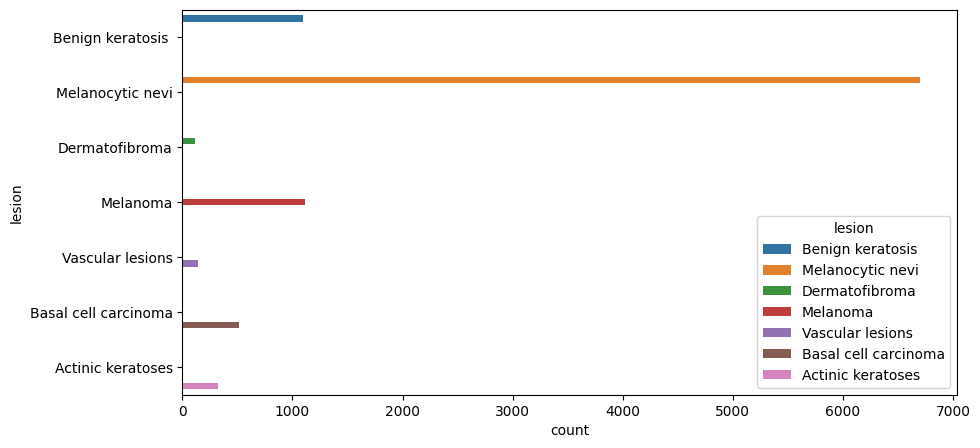

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

In [ ]:
# From above chart we can see that the dataset is highly imbalanced so we have to make it balanced

# Undersampling

In [30]:
from sklearn.utils import shuffle
num_sample = 200

df_df = df.loc[df['dx'] == "df"][0:115]
df_vasc = df.loc[df['dx'] == "vasc"][0:142]
df_akiec = (df.loc[df['dx'] == "akiec"]).sample(num_sample)
df_bcc = df.loc[df['dx'] == "bcc"][0:num_sample].sample(num_sample)
df_bkl = df.loc[df['dx'] == "bkl"][0:num_sample].sample(num_sample)
df_mel = df.loc[df['dx'] == "mel"][0:num_sample].sample(num_sample)
df_nv = df.loc[df['dx'] == "nv"][0:num_sample].sample(num_sample)

df = pd.concat([df_akiec, df_bcc, df_bkl, df_df, df_mel, df_nv, df_vasc])
df = shuffle(df)

<AxesSubplot:xlabel='count', ylabel='lesion'>

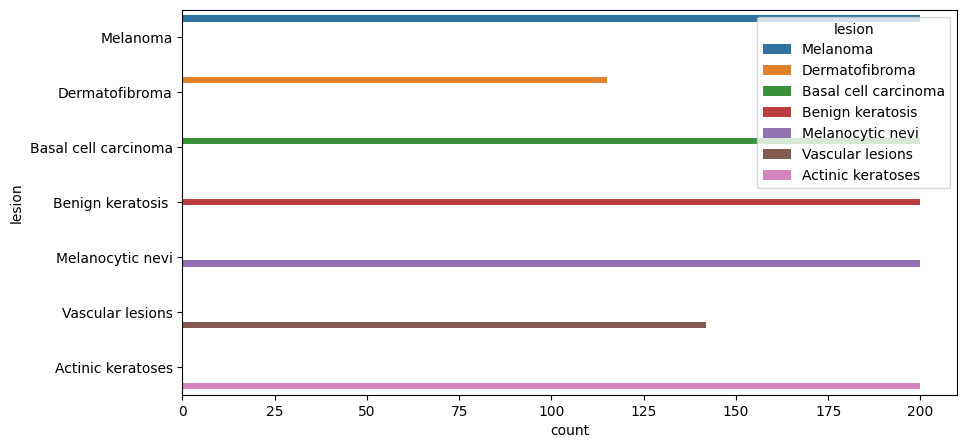

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

In [32]:
X = np.array(data)
Y = np.array(labels)


In [33]:
X = X.reshape(-1,28,28,3)

print( X.shape)
print( Y.shape)

(10015, 28, 28, 3)
(10015, 1)


In [34]:
#Normalizing the data

X = (X-np.mean(X))/np.std(X)

In [35]:
#Splitting the data into train and the test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

print( X_train.shape)
print( X_test.shape)
print( Y_train.shape)
print( Y_test.shape)

(7511, 28, 28, 3)
(2504, 28, 28, 3)
(7511, 1)
(2504, 1)


# Data Augmentation with ImageDataGenerator

In [36]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(X_train)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test)

train_data = train_datagen.flow(X_train, Y_train, batch_size = 64)
test_data = test_datagen.flow(X_test, Y_test, batch_size = 64)

In [42]:
#Model architecture

model = Sequential([
    
   
    
    Conv2D(8, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'),
    Conv2D(16, kernel_size = (3,3), activation = 'relu'),
    MaxPool2D(pool_size = (2,2)),
    
    

    Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    MaxPool2D(pool_size = (2,2), padding = 'same'),

    Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), padding = 'same'),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')]
)

# Adjusting learning rate and the optimizer

In [43]:


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

In [44]:
model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 8)         224       
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 16)        1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 16)        2320      
                                                                 
 conv2d_15 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                  

# Fitting the model

In [46]:
epochs = 25

history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = epochs,
                    callbacks=[learning_rate_reduction]) 

Epoch 1/25
94/94 [==============================] - 4s 25ms/step - loss: 1.1370 - accuracy: 0.6516 - val_loss: 0.9701 - val_accuracy: 0.6786 - lr: 7.5000e-04
Epoch 2/25
94/94 [==============================] - 1s 13ms/step - loss: 0.9503 - accuracy: 0.6688 - val_loss: 0.8899 - val_accuracy: 0.6786 - lr: 7.5000e-04
Epoch 3/25
94/94 [==============================] - 1s 12ms/step - loss: 0.8867 - accuracy: 0.6683 - val_loss: 0.8518 - val_accuracy: 0.6813 - lr: 7.5000e-04
Epoch 4/25
94/94 [==============================] - 1s 13ms/step - loss: 0.8626 - accuracy: 0.6821 - val_loss: 0.8396 - val_accuracy: 0.6900 - lr: 7.5000e-04
Epoch 5/25
94/94 [==============================] - 1s 13ms/step - loss: 0.8143 - accuracy: 0.7014 - val_loss: 0.8017 - val_accuracy: 0.7086 - lr: 7.5000e-04
Epoch 6/25
94/94 [==============================] - 1s 13ms/step - loss: 0.7877 - accuracy: 0.7106 - val_loss: 0.7784 - val_accuracy: 0.7232 - lr: 7.5000e-04
Epoch 7/25
94/94 [==============================] - 

# Test Accuracy

In [47]:
model_accuracy_test = model.evaluate(X_test, Y_test, verbose=0)[1]
print("the test model accuracy =",model_accuracy_test * 100)

the test model accuracy = 73.44249486923218


# Model Performance

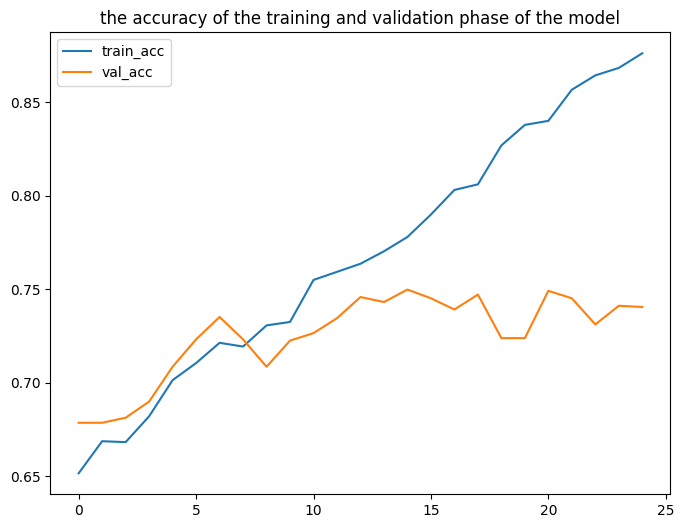

In [48]:
ACC = history.history['accuracy']
VAL_ACC = history.history['val_accuracy']

plt.figure(figsize=(8,6))
plt.title("the accuracy of the training and validation phase of the model")
plt.plot(ACC, label = 'train_acc')
plt.plot(VAL_ACC, label = 'val_acc')
plt.legend()

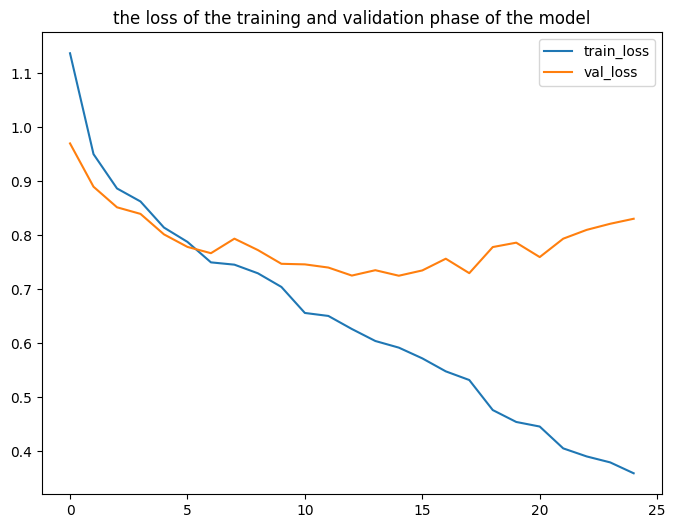

In [49]:
LOSS = history.history['loss']
VAL_LOSS = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.title("the loss of the training and validation phase of the model")
plt.plot(LOSS, label = 'train_loss')
plt.plot(VAL_LOSS, label = 'val_loss')
plt.legend()

# Confusion Matrix

79/79 [==============================] - 1s 5ms/step


<AxesSubplot:title={'center':'the confusion matrix of the model for train'}>

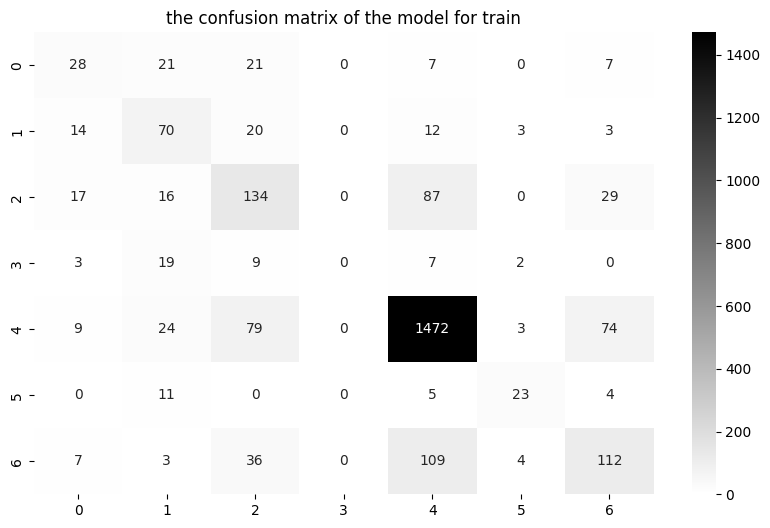

In [50]:
Y_true = np.array(Y_test)

Y_pred = model.predict(X_test)
Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

cm1 = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10, 6))
plt.title('the confusion matrix of the model for train')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary')

In [51]:
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

classification_report_model = classification_report(Y_true, Y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

          nv       0.36      0.33      0.35        84
         mel       0.43      0.57      0.49       122
         bkl       0.45      0.47      0.46       283
         bcc       0.00      0.00      0.00        40
       akiec       0.87      0.89      0.88      1661
        vasc       0.66      0.53      0.59        43
          df       0.49      0.41      0.45       271

    accuracy                           0.73      2504
   macro avg       0.46      0.46      0.46      2504
weighted avg       0.72      0.73      0.73      2504



C:\Users\dubey\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dubey\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dubey\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [52]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://78996535-6681-4f70-bc38-a637be75d4c6/assets


INFO:tensorflow:Assets written to: ram://78996535-6681-4f70-bc38-a637be75d4c6/assets
